In [85]:
import os
import numpy as np
import pandas as pd
import caer
import canaro
import gc
import cv2 as cv

In [86]:
img_size=(80,80)
channels=1
char_path=r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [87]:
char_dict={}
for char in os.listdir(char_path):
    char_dict[char]=len(os.listdir(os.path.join(char_path,char)))
    
char_dict=caer.sort_dict(char_dict,descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [88]:
characters=[]
count=0
for i in char_dict:
    characters.append(i[0])
    count+=1
    if count>=10:
        break
    
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [89]:
## Create Train Dataset
train=caer.preprocess_from_dir(char_path,characters,channels=channels,IMG_SIZE=img_size,isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
1 - homer_simpson
2 - homer_simpson
3 - homer_simpson
4 - homer_simpson
5 - homer_simpson
6 - homer_simpson
7 - homer_simpson
8 - homer_simpson
9 - homer_simpson
10 - homer_simpson
11 - homer_simpson
12 - homer_simpson
13 - homer_simpson
14 - homer_simpson
15 - homer_simpson
16 - homer_simpson
17 - homer_simpson
18 - homer_simpson
19 - homer_simpson
20 - homer_simpson
21 - homer_simpson
22 - homer_simpson
23 - homer_simpson
24 - homer_simpson
25 - homer_simpson
26 - homer_simpson
27 - homer_simpson
28 - homer_simpson
29 - homer_simpson
30 - homer_simpson
31 - homer_simpson
32 - homer_simpson
33 - homer_simpson
34 - homer_simpson
35 - homer_simpson
36 - homer_simpson
37 - homer_simpson
38 - homer_simpson
39 - homer_simpson
40 - homer_simpson
41 - homer_simpson
42 - homer_simpson
43 - homer_simpson
44 - homer_simpson
45 - homer_simpson
46 - homer_simpson
47 - homer_simps

/opt/conda/lib/python3.7/site-packages/caer/core.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(obj, dtype=dtype, order=order)


In [90]:
len(train)

13811

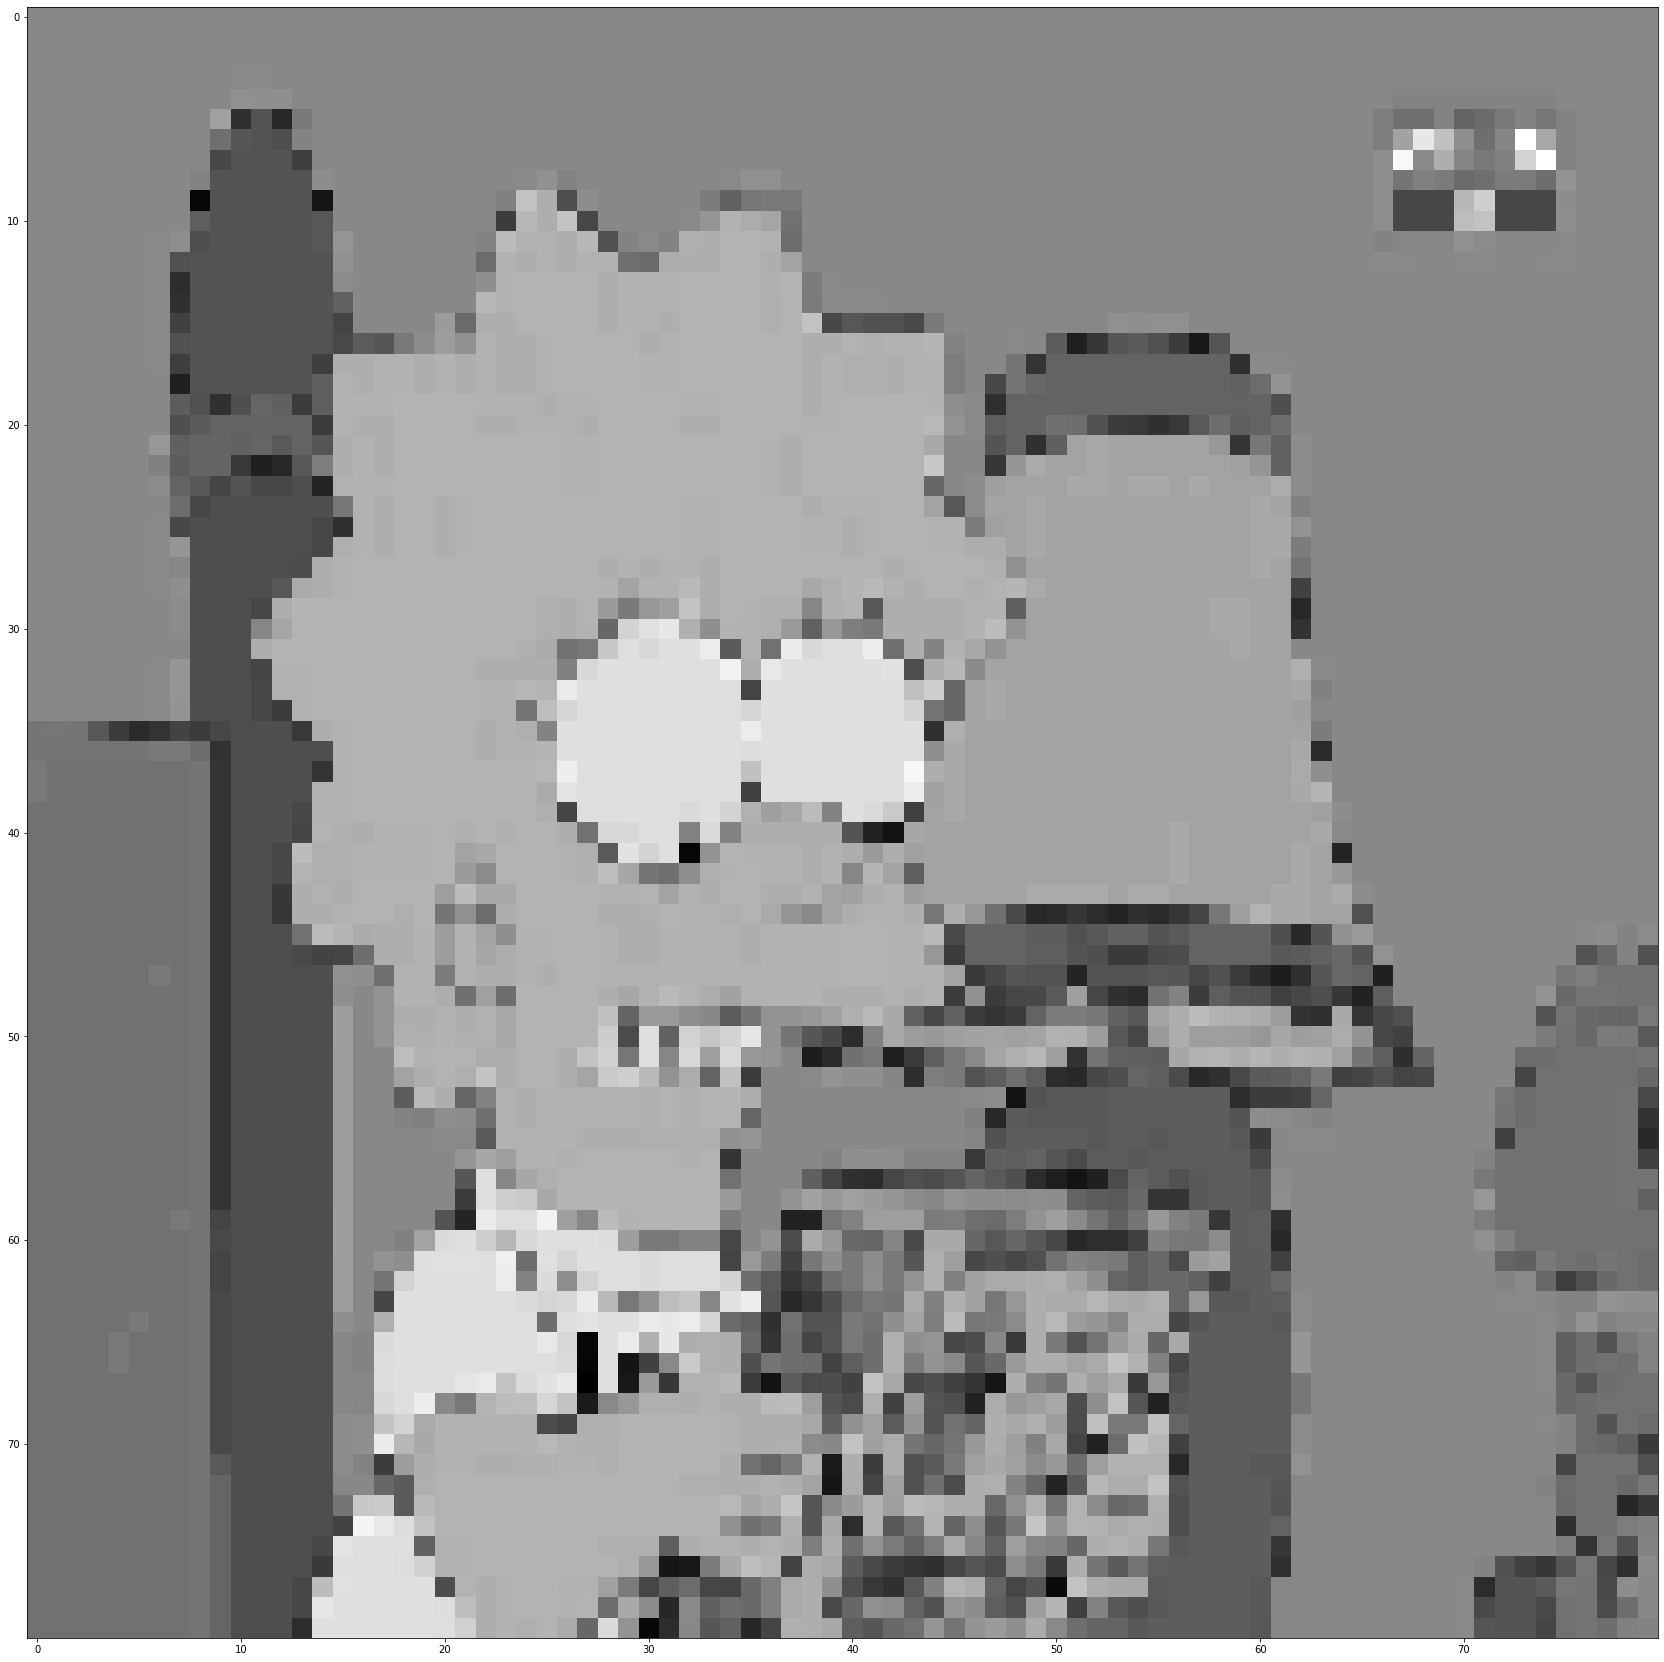

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0],cmap='gray')
plt.show()

In [92]:
features,labels = caer.sep_train(train,IMG_SIZE=img_size)
features.shape,labels.shape

((13811, 80, 80, 1), (13811,))

In [93]:
from tensorflow.keras.utils import to_categorical

#Normalize the features (0,1)
features = caer.normalize(features)
labels = to_categorical(labels,len(characters))
features.shape,labels.shape

((13811, 80, 80, 1), (13811, 10))

In [94]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = caer.train_val_split(features,labels,val_ratio=.2)

In [95]:
del train
del features
del labels
gc.collect()

4683

In [97]:
BATCH_SIZE=32
EPOCHS=10

## Image Data Generator

In [99]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [100]:
datagen=canaro.generators.imageDataGenerator()
train_gen=datagen.flow(x_train,y_train,batch_size=BATCH_SIZE)

In [101]:
x_val = np.array(x_val)
y_val = np.array(y_val)

In [102]:
model = canaro.models.createSimpsonsModel(IMG_SIZE=img_size,channels=channels,output_dim=len(characters),
                                         loss='binary_crossentropy',decay=1e-6,learning_rate=0.001,
                                         momentum=0.9,nesterov=True)

In [103]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [104]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]

In [106]:
training=model.fit(train_gen,
                  steps_per_epoch=len(x_train)//BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_val,y_val),
                  validation_steps=len(y_val)//BATCH_SIZE,
                  callbacks=callbacks_list)

Epoch 1/10
345/345 [==============================] - 13s 28ms/step - loss: 0.3920 - accuracy: 0.1445 - val_loss: 0.3335 - val_accuracy: 0.1661
Epoch 2/10
345/345 [==============================] - 9s 27ms/step - loss: 0.3238 - accuracy: 0.1616
Epoch 3/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3233 - accuracy: 0.1633
Epoch 4/10
345/345 [==============================] - 8s 24ms/step - loss: 0.3220 - accuracy: 0.1686
Epoch 5/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3151 - accuracy: 0.1860
Epoch 6/10
345/345 [==============================] - 9s 27ms/step - loss: 0.3069 - accuracy: 0.2257
Epoch 7/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3030 - accuracy: 0.2545
Epoch 8/10
345/345 [==============================] - 8s 24ms/step - loss: 0.3002 - accuracy: 0.2572
Epoch 9/10
345/345 [==============================] - 9s 25ms/step - loss: 0.2994 - accuracy: 0.2664
Epoch 10/10
345/345 [===========================

In [107]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

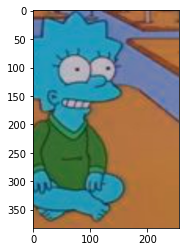

In [119]:
test_path=r'../input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0003.jpg'

img=cv.imread(test_path)
plt.imshow(img,cmap='gray')
plt.show()

In [120]:
def prepare(img):
    img=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img=cv.resize(img,img_size)
    img=caer.reshape(img,img_size,1)
    return img

In [121]:
pred = model.predict(prepare(img))
print(characters[np.argmax(pred[0])])

lisa_simpson
